In [1]:
import torch
import numpy as np
from tqdm import tqdm
from scipy.stats.distributions import chi2
from scipy.stats import pearsonr
import pickle

import matplotlib.pyplot as plt
from scipy.stats import linregress
import seaborn as sns
import random
import matplotlib.animation as animation
import sys, os

from utils.plots import *
from utils.funcs import *
from utils.visualize_network import *
from utils.visualize_hidden_network import *

from boltzmann_machines.cp_rtrbm import RTRBM
from boltzmann_machines.cp_rbm import RBM

from data.load_data import *
from data.mock_data import *
from data.reshape_data import *
from data.poisson_data_v import PoissonTimeShiftedData
from utils.moments_plot import infer_and_get_moments_plot



In [11]:
n_h = 3
duration = 370
dt = 1e-2

C = np.array([0.2, 0.4, 0.6, 0.8, 1])
N_machines = 2
O = np.zeros([len(C), 2, n_h])
r2v = np.zeros([len(C), N_machines])
r2v2, r2h, r2h2, r2vh = np.zeros_like(r2v), np.zeros_like(r2v), np.zeros_like(r2v), np.zeros_like(r2v)

for i, corr in enumerate(C):
    for n in range(N_machines):
        s = PoissonTimeShiftedData(
            neurons_per_population=20,
            n_populations=n_h,
            n_batches=1,
            duration=duration, dt=dt,
            fr_mode='gaussian', delay=1, temporal_connections='random', corr=corr, show_connection=False, compute_overlap=True,
            fr_range=[50, 100], mu_range=[0, duration], std_range=[2 * dt, 3 * dt], n_range=[0.005, 0.03])
        O[i, n, :] = torch.mean(s.overlap_distribution)
        data = reshape(s.data[..., 0], 100, 370)
        train, test = data[..., :300], data[..., 300:]
        rtrbm = RTRBM(train, N_H=n_h, device='cpu')
        rtrbm.learn(n_epochs=10, lr_schedule='geometric_decay', batch_size=10, CDk=10, mom=0.6, wc=0, min_lr=5e-4, max_lr=5e-3, sp=1e-6, x=2)
        path2dir = r'C:\Users\sebas\OneDrive\Intern\rtrbm_master\results\Poisson Artificial Data'
        torch.save(rtrbm, path2dir + r'\rtrbm_corr'+str(corr)+'_n'+str(n))
        torch.save([s, train, test], path2dir + r'\PMT_train_test_corr'+str(corr)+'_n'+str(n))
        [vt, vs, ht, hs], [r2v[i, n], r2v2[i, n], r2h[i, n], r2h2[i, n], r2vh[i, n]] =  infer_and_get_moments_plot(path2dir+ r'\rtrbm_corr'+str(corr)+'_n'+str(n), test=test, pre_gibbs_k=100, gibbs_k=100, mode=1, n_batches=None, n=1000, m=50000, plot=False, machine='rtrbm')
        _, _, _ =  infer_and_get_moments_plot(path2dir+ r'\rtrbm_corr'+str(corr)+'_n'+str(n), test=test, pre_gibbs_k=100, gibbs_k=100, mode=1, n_batches=None, n=1000, m=50000, plot=False, machine='rtrbm')



KeyboardInterrupt: 

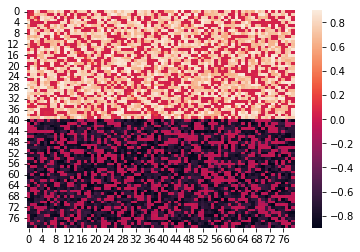

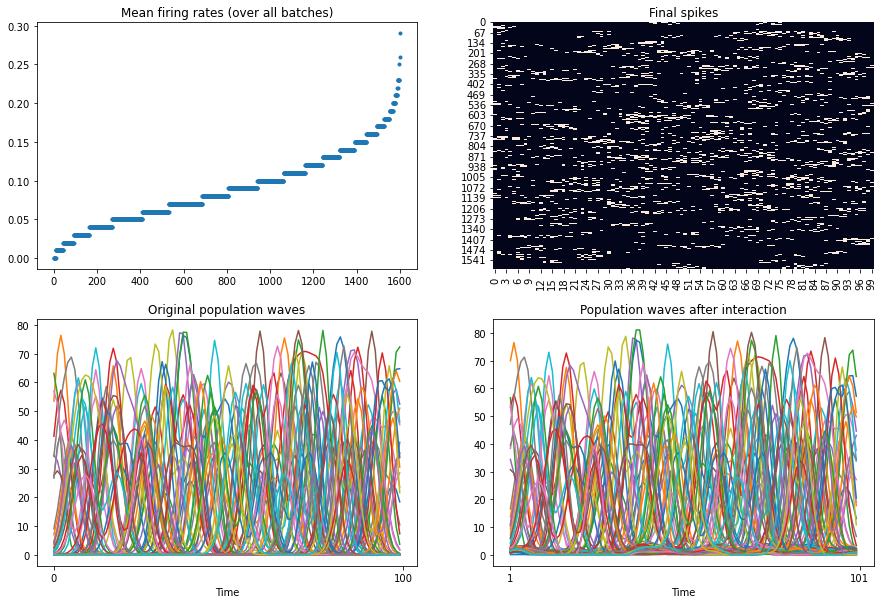

tensor(0.2303) tensor(0.2012)


In [3]:
n_h = 3
duration = 370
dt = 1e-2
corr=1

s = PoissonTimeShiftedData(
    neurons_per_population=20,
    n_populations=n_h,
    n_batches=1,
    duration=duration, dt=dt,
    fr_mode='gaussian', delay=1, temporal_connections='random', corr=corr, show_connection=False, compute_overlap=True,
    fr_range=[50, 100], mu_range=[0, duration], std_range=[2 * dt, 5 * dt], n_range=[0.018, 0.02])
s.plot_stats(T=1000)

KeyboardInterrupt: 

In [ ]:
data = reshape(s.data[..., 0], 100, 370)
train, test = data[..., :300], data[..., 300:]
rtrbm = RTRBM(train, N_H=n_h, device='cpu')
rtrbm.learn(n_epochs=10, lr_schedule='geometric_decay', batch_size=10, CDk=10, mom=0.6, wc=0, min_lr=5e-4, max_lr=5e-3, sp=1e-6, x=2)
path2dir = r'C:\Users\sebas\OneDrive\Intern\rtrbm_master\results\Poisson Artificial Data'
torch.save(rtrbm, path2dir + r'\rtrbm_corr'+str(corr)+'_n'+str(n))
torch.save([s, train, test], path2dir + r'\PMT_train_test_corr'+str(corr)+'_n'+str(n))
[vt, vs, ht, hs], [r2v[i, n], r2v2[i, n], r2h[i, n], r2h2[i, n], r2vh[i, n]] =  infer_and_get_moments_plot(path2dir+ r'\rtrbm_corr'+str(corr)+'_n'+str(n), test=test, pre_gibbs_k=100, gibbs_k=100, mode=1, n_batches=None, n=1000, m=50000, plot=False, machine='rtrbm')
_, _, _ =  infer_and_get_moments_plot(path2dir+ r'\rtrbm_corr'+str(corr)+'_n'+str(n), test=test, pre_gibbs_k=100, gibbs_k=100, mode=1, n_batches=None, n=1000, m=50000, plot=False, machine='rtrbm')

